# Preliminaries

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator


plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#Load original dataframes
allDataCohort = pd.read_csv("../Data Validation/ARIC/Original DataFrames/AllDataAricCohort.csv", sep=",", index_col='ID')
allDataComm = pd.read_csv("../Data Validation/ARIC/Original DataFrames/AllDataAricComm.csv", sep=",", index_col='ID') 
hemoCohort = pd.read_csv("../Data Validation/ARIC/Original DataFrames/HemoAricCohort.csv", sep=",", index_col='ID') 
hemoComm = pd.read_csv("../Data Validation/ARIC/Original DataFrames/HemoAricComm.csv", sep=",", index_col='ID') 
cohortLabels = pd.read_csv("../Data Validation/ARIC/Original DataFrames/LabelsAricCohort.csv", sep=",", index_col='ID')
commLabels = pd.read_csv("../Data Validation/ARIC/Original DataFrames/LabelsAricComm.csv", sep=",", index_col='ID')


# Cluster Labels

In [3]:
#CLUSTERING FUNCTIONS
def clusterFindK(X): #find optimal num k
    sum_of_squared_distances = []
    silhouette = []
    K = range(1,16)
    for k in K:
        k_means = KMeans(n_clusters=k, init='k-means++',n_init=50, max_iter=500, tol=1e-04, random_state=0)
        model = k_means.fit(X)
        sum_of_squared_distances.append(k_means.inertia_)
        if k != 1:
            silhouette.append(silhouette_score(X, k_means.labels_))
        

    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('K Number of Clusters')
    plt.ylabel('Sum of Squared Error')
    plt.title('Elbow Method to Find Optimal K')
    plt.show()
    
    kl = KneeLocator(K, sum_of_squared_distances, curve="convex", direction="decreasing")
    print("Using the elbow method, the optimal number of clusters is", kl.elbow)
    
    plt.plot(range(2,16), silhouette)
    plt.xlabel("K Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    
    print("Using Silhouette Scores, the optimal number of clusters is", silhouette.index(max(silhouette))+2)
    
def kMeans(X, K): #perform k means clustering
    km = KMeans(n_clusters=K, init='k-means++',n_init=50, max_iter=500, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)
    print("Lowest SSE", km.inertia_) #lowest sum of squared error value
    print("Number of iterations needed for convergence", km.n_iter_) #number of iterations neded to converge
    print("Y_km labels", y_km)
    
    return y_km

def plotPCAClusters(X, y_km, K, name): #plot clusters from pca
    df = pd.DataFrame(X, columns=["Component_1", "Component_2"])
    df['Cluster'] = y_km + 1
    plt.figure(figsize=(16,7))
    numColors = len(set(y_km))
    sns.scatterplot(x='Component_1', y='Component_2', hue='Cluster', palette=sns.color_palette('hls', numColors), data=df, legend='full')
    plt.title("Resulting Score Clusters")
    plt.savefig("Figures/Score_Clusters_" + name + ".png")

    plt.show()
    
    return df

def plotClusters(X, y_km, columns, K): #plot original data clusters
    X['cluster'] = y_km
    plt.figure(figsize=(16,7))
    numColors = len(set(y_km))
    sns.scatterplot(x=columns[0], y=columns[1], hue='cluster',palette=sns.color_palette('hls', numColors), data=X, legend='full')
    plt.show()
    
    return X

def compareClusters(dt, K): #compare details of clusters
    clusters = []
    clusterDesc = []
    for num in range(K):
        cls = dt[dt['cluster'] == num]
        clusters.append(cls)

        print("Cluster ", num)
        print(cls.describe())
        clusterDesc.append(cls.describe())
        
    return clusters, clusterDesc

#compare distributions of clusters
def distPlotsForClusters(cls, cols, name):
    clusters = copy.deepcopy(cls)
    for c in cols:
        f, ax = plt.subplots(figsize=(11,9))
        for i in range(len(clusters)):
            currCls = pd.DataFrame(clusters[i])
            currCls = currCls.replace(np.inf, 0)
            sns.distplot(currCls[c], ax=ax, label=i)
        
        plt.title(c+ ' Distribution by Cluster')
        plt.ylabel("Distribution Value")
        plt.legend(title="Cluster")
        
        plt.savefig("Figures/" + name + "/Clusters"+c+".png")

## Hemo Dataset - Cohort

In [4]:
#try clustering to find similar groups using PCA
hemo = copy.deepcopy(hemoCohort)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)
scaler = MinMaxScaler()#scale data
hemo.loc[:,:] = scaler.fit_transform(hemo)
pca = PCA(n_components=2)
data = pca.fit_transform(hemo)

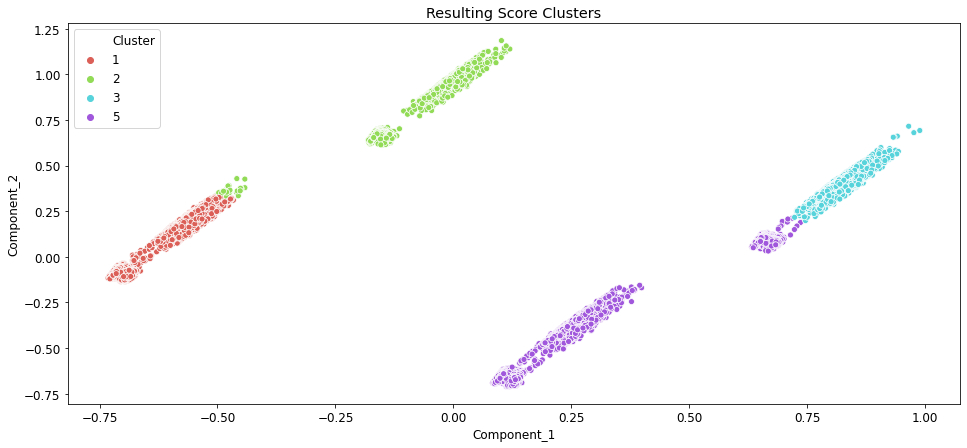

In [5]:
# y_km = kMeans(data, 5)
#load model
model = pickle.load(open('ClusterModels/HemoCluster.sav', 'rb'))
y_km = model.predict(data)

pcaDF = plotPCAClusters(data, y_km, 5, "Hemo_ARIC_Cohort")

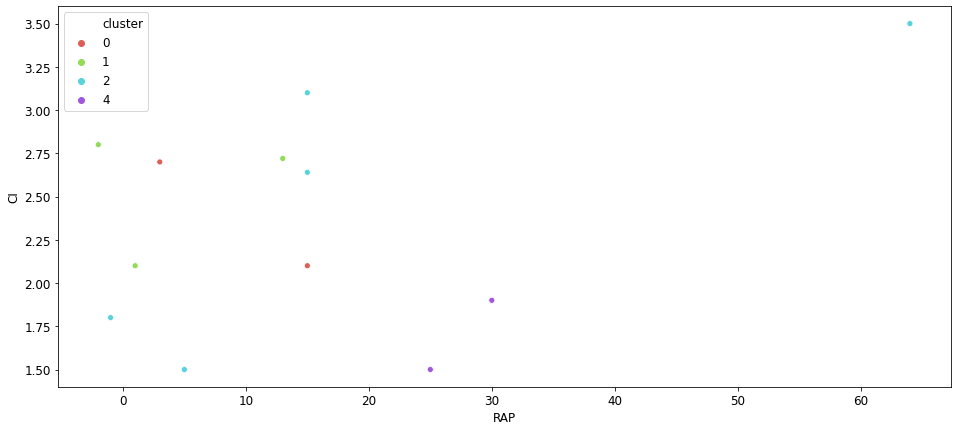

In [6]:
hemoDF = plotClusters(hemoCohort, y_km, ["RAP", "CI"], 5)

In [7]:
#Add class labels
hemoDF['Death'] = cohortLabels['Death']

clusters, clusterDesc = compareClusters(hemoDF, 5)

Cluster  0
               Age  Gender    Race          EjF        RAP        PAS     PAD  \
count  5093.000000  5093.0  5093.0  2286.000000  12.000000  12.000000  5093.0   
mean     77.934616     1.0     1.0    43.561242  18.166667  43.166667     0.0   
std       6.135694     0.0     0.0    15.206225  26.964061  19.441443     0.0   
min      61.000000     1.0     1.0     2.000000   2.000000  23.000000     0.0   
25%      73.000000     1.0     1.0    30.000000   3.000000  24.000000     0.0   
50%      78.000000     1.0     1.0    45.000000   7.000000  41.500000     0.0   
75%      82.000000     1.0     1.0    55.000000  15.000000  51.000000     0.0   
max      93.000000     1.0     1.0    85.000000  75.000000  78.000000     0.0   

         PAMN       PCWP        CO  ...    PAPP           SVR       RAT  \
count  5093.0   8.000000  8.000000  ...  5093.0      8.000000  8.000000   
mean      0.0  22.000000  3.050000  ...     0.0   6727.650030  0.257634   
std       0.0   4.598136  2.114575

Cluster  4
               Age  Gender         Race          EjF        RAP         PAS  \
count  6773.000000  6773.0  6773.000000  3084.000000   8.000000    8.000000   
mean     78.294552     2.0     1.228112    49.496109  19.500000   67.750000   
std       6.212868     0.0     0.419646    15.398069   9.149551   27.384824   
min      61.000000     2.0     1.000000     8.000000   8.000000   42.000000   
25%      74.000000     2.0     1.000000    40.000000  13.250000   51.750000   
50%      79.000000     2.0     1.000000    55.000000  20.000000   59.500000   
75%      83.000000     2.0     1.000000    60.000000  26.250000   75.500000   
max      93.000000     2.0     2.000000    95.000000  30.000000  110.000000   

          PAD    PAMN       PCWP       CO  ...    PAPP          SVR       RAT  \
count  6773.0  6773.0   8.000000  4.00000  ...  6773.0     4.000000  8.000000   
mean      0.0     0.0  22.250000  2.70000  ...     0.0  3609.931034  0.940285   
std       0.0     0.0   8.924285  

In [8]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_Hemo_ARIC_Cohort.csv")

In [9]:
hemoDF.to_csv("Clustered_HemoDF_ARIC_Cohort.csv")

Save preprocessed data  
Cluster --> Score   

In [10]:
#Get means for each cluster

clsScDF = pd.DataFrame()
clsScDF.index.name = 'Cluster'

scores = [1,2,3,4,5]
dthMn = descSummary.loc['mean']['Death'].to_numpy()

In [11]:
dthScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(dthMn):
    dthScores[v] = scores[cnt]
    cnt += 1
    
clsScDF['DeathMean'] = dthMn
clsScDF['DeathScores'] = dthScores

clsScDF

,DeathMean,DeathScores
0,0.072256,4
1,0.067146,3
2,0.050257,1
3,NaN,5
4,0.052266,2


Make sure to add final scores assignment

In [12]:
#Save fully preprocessed score data
clusNums = hemoDF['cluster']

#Death Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['DeathScores']))
hemoDF['ScoreDeath'] = labels

hemoDF = hemoDF.drop(columns=["cluster"])
hemoDF = hemoDF.drop(columns=["Death"])


hemoDF

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,PPP,PAPP,SVR,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,ScoreDeath
ID,,,,,,,,,,,,,,,,,,,,,
S105655,76,1,1,NaN,NaN,NaN,0,0,NaN,NaN,...,0.546392,0,NaN,NaN,1.492958,0,NaN,NaN,NaN,4
S105655,76,1,1,NaN,NaN,NaN,0,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,4
S105737,76,2,1,40.0,NaN,NaN,0,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,2
S105737,76,2,1,40.0,NaN,NaN,0,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,2
S106083,66,2,1,NaN,NaN,NaN,0,0,NaN,NaN,...,0.507042,0,NaN,NaN,0.734694,0,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S214744,74,2,1,NaN,NaN,NaN,0,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,2
S214752,80,2,1,60.0,NaN,NaN,0,0,NaN,NaN,...,0.521739,0,NaN,NaN,1.153846,0,NaN,NaN,NaN,2
S214752,80,2,1,60.0,NaN,NaN,0,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,2


In [13]:
hemoDF.to_csv("../Data Validation/ARIC/Preprocessed Data/Clustered_HemoDF_ARIC_Cohort.csv")

## All Data - Cohort

In [14]:
#try clustering to find similar groups using PCA
allData = copy.deepcopy(allDataCohort)
allData = allData.replace(np.inf, 0)
allData = allData.fillna(0)
scaler = MinMaxScaler()#scale data
allData.loc[:,:] = scaler.fit_transform(allData)
pca = PCA(n_components=2)
data = pca.fit_transform(allData)

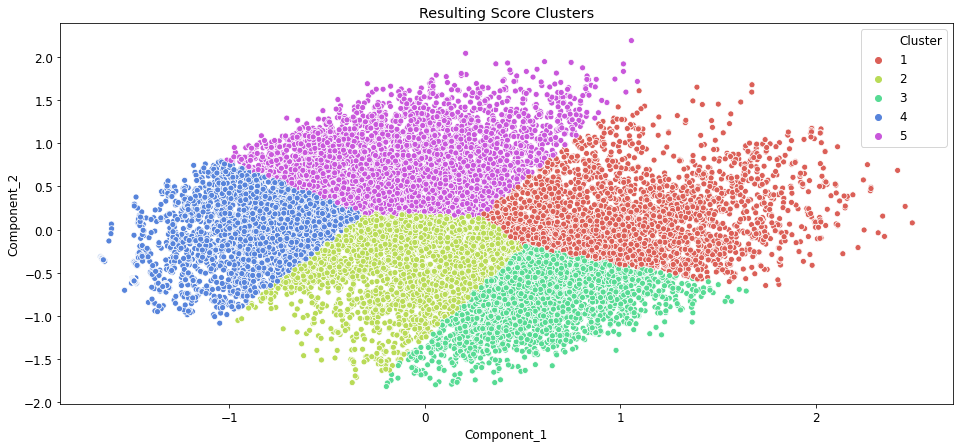

In [15]:
model = pickle.load(open('ClusterModels/AllDataCluster.sav', 'rb'))
y_km = model.predict(data)

pcaDF = plotPCAClusters(data, y_km, 5, 'AllData_ARIC_Cohort')

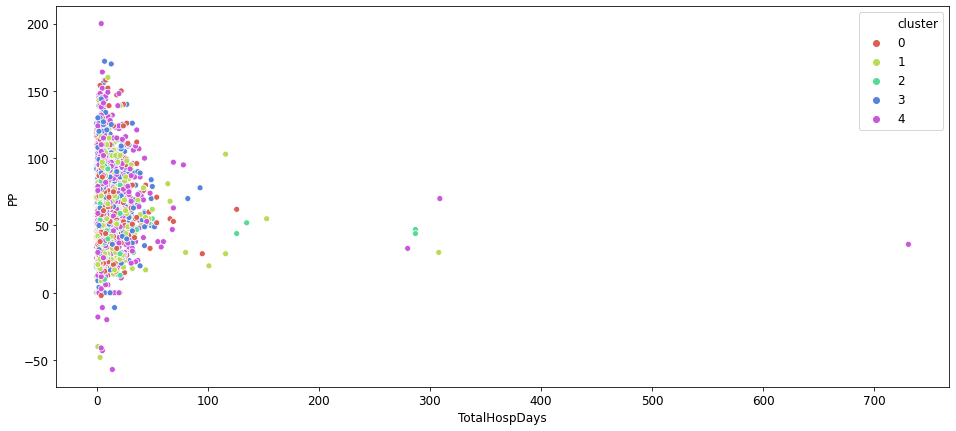

In [16]:
allDF = plotClusters(allDataCohort, y_km, ["TotalHospDays", "PP"], 5)

In [17]:
#Add class labels
allDF['Death'] = cohortLabels['Death']

clusters, clusterDesc = compareClusters(allDF, 5)

Cluster  0
              Age       Gender         Race           Wt          BMI  \
count  2753.00000  2753.000000  2753.000000  2353.000000  2656.000000   
mean     77.80385     1.360697     1.219760    84.187614    11.269531   
std       5.92725     0.480290     0.414159    19.913827    15.892638   
min      62.00000     1.000000     1.000000    32.295777     0.000000   
25%      73.00000     1.000000     1.000000    69.399633     0.000000   
50%      78.00000     1.000000     1.000000    81.646627     0.000000   
75%      82.00000     2.000000     1.000000    96.500000    25.980080   
max      93.00000     2.000000     2.000000   213.495000   200.413223   

       InitialHospDays  TotalHospDays        NYHA   MLHFS           AF  ...  \
count           2753.0    2753.000000  186.000000  2753.0  2753.000000  ...   
mean               0.0       6.601889    0.215054     0.0     0.778787  ...   
std                0.0      16.201803    0.789792     0.0     0.415139  ...   
min            

Cluster  4
               Age       Gender         Race           Wt          BMI  \
count  3964.000000  3964.000000  3964.000000  3378.000000  3781.000000   
mean     76.014127     1.594349     1.522704    85.316341     8.450607   
std       6.167631     0.491080     0.499547    20.720448    14.532263   
min      61.000000     1.000000     1.000000    26.807309     0.000000   
25%      72.000000     1.000000     1.000000    70.325000     0.000000   
50%      76.000000     2.000000     2.000000    83.256880     0.000000   
75%      80.000000     2.000000     2.000000    98.200000    21.300161   
max      92.000000     2.000000     2.000000   201.800000    74.033284   

       InitialHospDays  TotalHospDays        NYHA   MLHFS           AF  ...  \
count           3964.0    3959.000000  452.000000  3964.0  3964.000000  ...   
mean               0.0       7.068957    0.141593     0.0     0.023713  ...   
std                0.0      14.779157    0.657446     0.0     0.152174  ...   
min   

In [18]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_AllData_ARIC_Cohort.csv")

In [19]:
allDF.to_csv("Clustered_allDataDF_ARIC_Cohort.csv")

Save preprocessed data  
Cluster --> Score   

In [20]:
#Get means for each cluster

clsScDF = pd.DataFrame()
clsScDF.index.name = 'Cluster'

scores = [1,2,3,4,5]
dthMn = descSummary.loc['mean']['Death'].to_numpy()

In [21]:
dthScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(dthMn):
    dthScores[v] = scores[cnt]
    cnt += 1
    
clsScDF['DeathMean'] = dthMn
clsScDF['DeathScores'] = dthScores

clsScDF

,DeathMean,DeathScores
0,0.037414,2
1,0.086758,5
2,0.079340,4
3,0.070728,3
4,0.037336,1


Make sure to add final scores assignment

In [22]:
#Save fully preprocessed score data
clusNums = allDF['cluster']

#Death Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['DeathScores']))
allDF['ScoreDeath'] = labels

allDF = allDF.drop(columns=["cluster"])
allDF = allDF.drop(columns=["Death"])

allDF

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,EjF,BPDIAS,BPSYS,HR,PV,MAP,PP,PPP,PPRatio,ScoreDeath
ID,,,,,,,,,,,,,,,,,,,,,
S105655,76,1,1,NaN,0.000000,0,11.0,NaN,0,0,...,NaN,88.0,194.0,0,0,252.666667,106.0,0.546392,1.492958,1
S105655,76,1,1,NaN,NaN,0,11.0,NaN,0,0,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,1
S105737,76,2,1,67.70,0.000000,0,3.0,NaN,0,1,...,40.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,5
S105737,76,2,1,63.30,28.185923,0,3.0,NaN,0,1,...,40.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,4
S106083,66,2,1,86.00,0.000000,0,10.0,0.0,0,0,...,NaN,70.0,142.0,0,0,188.666667,72.0,0.507042,0.734694,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S214744,74,2,1,87.10,35.121038,0,3.0,NaN,0,1,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,2
S214752,80,2,1,66.90,0.000000,0,2.0,NaN,0,0,...,60.0,110.0,230.0,0,0,303.333333,120.0,0.521739,1.153846,3
S214752,80,2,1,67.10,24.616617,0,2.0,NaN,0,0,...,60.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,3


In [23]:
allDF.to_csv("../Data Validation/ARIC/Preprocessed Data/Clustered_AllData_ARIC_Cohort.csv")

## Hemo Dataset - Comm

In [24]:
#try clustering to find similar groups using PCA
hemo = copy.deepcopy(hemoComm)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)
scaler = MinMaxScaler()#scale data
hemo.loc[:,:] = scaler.fit_transform(hemo)
pca = PCA(n_components=2)
data = pca.fit_transform(hemo)

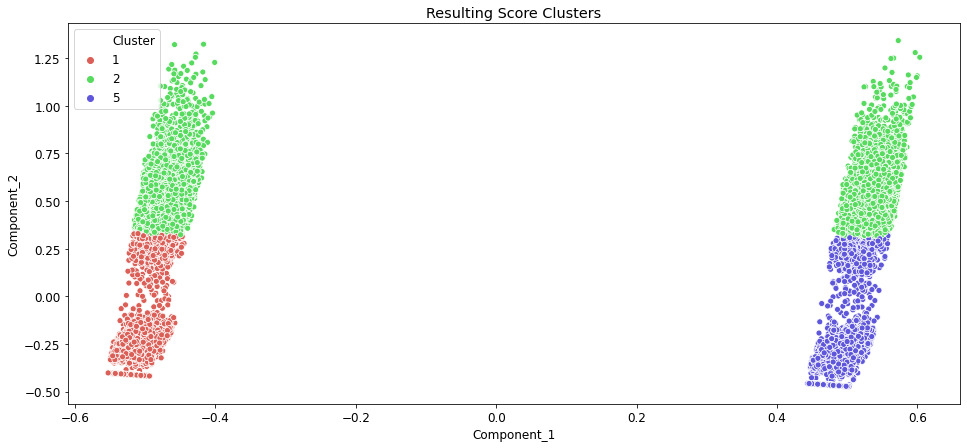

In [25]:
model = pickle.load(open('ClusterModels/HemoCluster.sav', 'rb'))
y_km = model.predict(data)

pcaDF = plotPCAClusters(data, y_km, 5, "Hemo_ARIC_Comm")

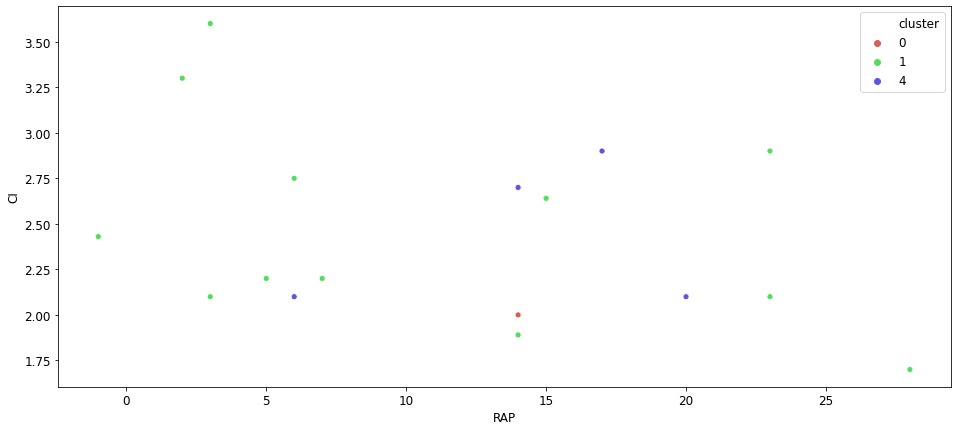

In [26]:
hemoDF = plotClusters(hemoComm, y_km, ["RAP", "CI"], 5)

In [27]:
#Add class labels
hemoDF['Death'] = cohortLabels['Death']

clusters, clusterDesc = compareClusters(hemoDF, 5)

Cluster  0
               Age  Gender    Race          EjF        RAP        PAS     PAD  \
count  5353.000000  5353.0  5353.0  1539.000000   5.000000   6.000000  5353.0   
mean     70.106669     1.0     0.0    39.509422  16.600000  43.500000     0.0   
std       8.592525     0.0     0.0    16.968084  11.567195   9.974969     0.0   
min      55.000000     1.0     0.0     2.000000   2.000000  35.000000     0.0   
25%      63.000000     1.0     0.0    25.000000  14.000000  36.250000     0.0   
50%      70.000000     1.0     0.0    40.000000  14.000000  40.000000     0.0   
75%      78.000000     1.0     0.0    55.000000  19.000000  48.250000     0.0   
max      84.000000     1.0     0.0    85.000000  34.000000  60.000000     0.0   

         PAMN      PCWP        CO  ...    PAPP          SVR       RAT  \
count  5353.0   5.00000  8.000000  ...  5353.0     4.000000  5.000000   
mean      0.0  15.60000  4.837500  ...     0.0  1468.396606  1.013111   
std       0.0   7.95613  1.575652  ...  

In [28]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_Hemo_ARIC_Comm.csv")

In [29]:
hemoDF.to_csv("Clustered_HemoDF_ARIC_Comm.csv")

Save preprocessed data  
Cluster --> Score   

In [30]:
#Get means for each cluster

clsScDF = pd.DataFrame()
clsScDF.index.name = 'Cluster'

scores = [1,2,3,4,5]
dthMn = descSummary.loc['mean']['Death'].to_numpy()

In [31]:
dthScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(dthMn):
    dthScores[v] = scores[cnt]
    cnt += 1
    
clsScDF['DeathMean'] = dthMn
clsScDF['DeathScores'] = dthScores

clsScDF

,DeathMean,DeathScores
0,0.107843,3
1,0.057143,2
2,NaN,4
3,NaN,5
4,0.056000,1


Make sure to add final scores assignment

In [32]:
#Save fully preprocessed score data
clusNums = hemoDF['cluster']

#Death Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['DeathScores']))
hemoDF['ScoreDeath'] = labels

hemoDF = hemoDF.drop(columns=["cluster"])
hemoDF = hemoDF.drop(columns=["Death"])


hemoDF

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,PPP,PAPP,SVR,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,ScoreDeath
ID,,,,,,,,,,,,,,,,,,,,,
S106083,66,2,0,NaN,NaN,NaN,0,0,NaN,NaN,...,0.507042,0,NaN,NaN,0.734694,0,NaN,NaN,NaN,2
S106083,66,2,0,NaN,NaN,NaN,0,0,NaN,NaN,...,0.437500,0,NaN,NaN,0.571429,0,NaN,NaN,NaN,2
S106611,67,1,0,30.0,NaN,NaN,0,0,NaN,NaN,...,0.557292,0,NaN,NaN,1.445946,0,NaN,NaN,NaN,2
S106611,67,1,0,30.0,NaN,NaN,0,0,NaN,NaN,...,0.513514,0,NaN,NaN,1.027027,0,NaN,NaN,NaN,2
S106644,76,2,0,NaN,NaN,NaN,0,0,NaN,NaN,...,0.601227,0,NaN,NaN,1.126437,0,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S210889,80,2,0,20.0,NaN,NaN,0,0,NaN,NaN,...,0.444444,0,NaN,NaN,0.937500,0,NaN,NaN,NaN,2
S210906,82,2,0,NaN,NaN,NaN,0,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,1
S210906,82,2,0,NaN,NaN,NaN,0,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,1


In [33]:
hemoDF.to_csv("../Data Validation/ARIC/Preprocessed Data/Clustered_HemoDF_ARIC_Comm.csv")

## All Data - Cohort

In [34]:
#try clustering to find similar groups using PCA
allData = copy.deepcopy(allDataComm)
allData = allData.replace(np.inf, 0)
allData = allData.fillna(0)
scaler = MinMaxScaler()#scale data
allData.loc[:,:] = scaler.fit_transform(allData)
pca = PCA(n_components=2)
data = pca.fit_transform(allData)

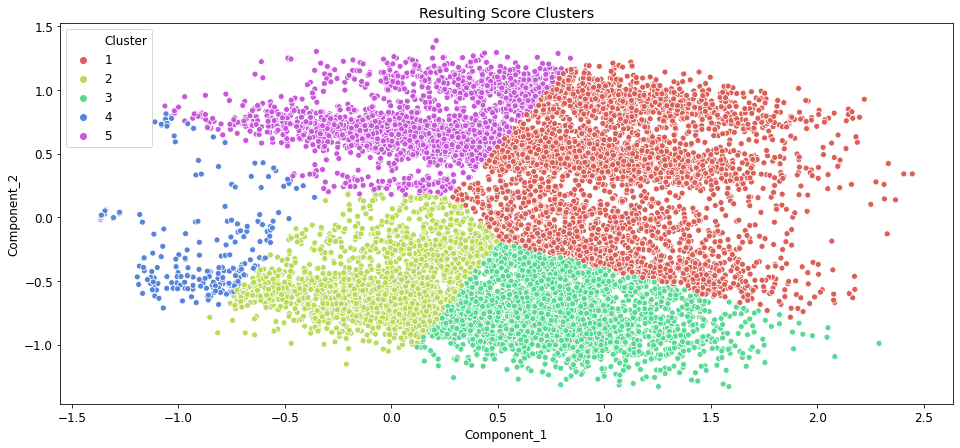

In [35]:

model = pickle.load(open('ClusterModels/AllDataCluster.sav', 'rb'))
y_km = model.predict(data)

pcaDF = plotPCAClusters(data, y_km, 5, 'AllData_ARIC_Comm')

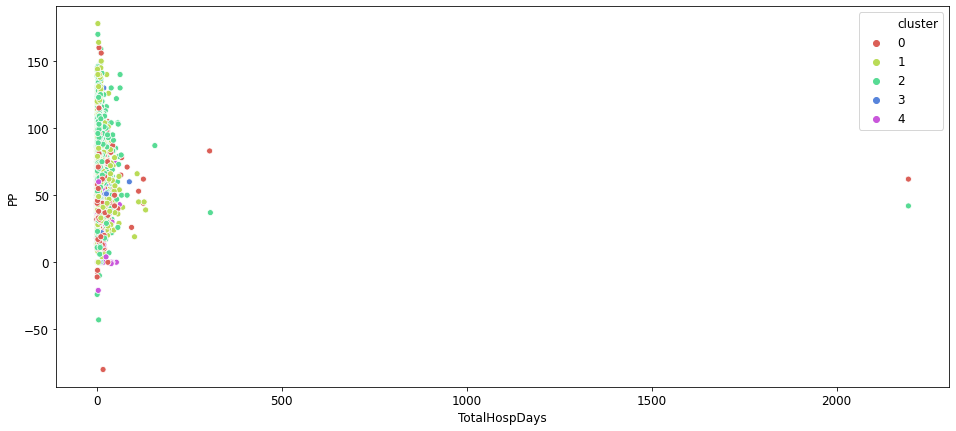

In [36]:
allDF = plotClusters(allDataComm, y_km, ["TotalHospDays", "PP"], 5)

In [37]:
#Add class labels
allDF['Death'] = cohortLabels['Death']

clusters, clusterDesc = compareClusters(allDF, 5)

Cluster  0
               Age       Gender    Race           Wt          BMI  \
count  4103.000000  4103.000000  4103.0  3308.000000  3628.000000   
mean     70.877163     1.460639     0.0    89.022551    24.702184   
std       8.443897     0.498509     0.0    25.103959    16.254416   
min      55.000000     1.000000     0.0    22.452822     0.000000   
25%      64.000000     1.000000     0.0    71.775000    19.479865   
50%      71.000000     1.000000     0.0    85.290000    27.157648   
75%      78.000000     2.000000     0.0   102.000000    33.731796   
max      85.000000     2.000000     0.0   220.800000   301.623970   

       InitialHospDays  TotalHospDays        NYHA   MLHFS           AF  ...  \
count           4103.0    4103.000000  393.000000  4103.0  4103.000000  ...   
mean               0.0       7.979527    0.221374     0.0     0.480380  ...   
std                0.0      36.079907    0.829526     0.0     0.499676  ...   
min                0.0       0.000000    0.000000  

               Age      Gender    Race           Wt          BMI  \
count  2319.000000  2319.00000  2319.0  1665.000000  1929.000000   
mean     71.031479     1.50884     0.0    85.125348    30.058663   
std       8.502314     0.50003     0.0    29.782003    11.430834   
min      55.000000     1.00000     0.0    23.425324     0.000000   
25%      64.000000     1.00000     0.0    65.500000    23.174131   
50%      72.000000     2.00000     0.0    80.200000    27.809560   
75%      78.000000     2.00000     0.0    99.200000    34.683711   
max      84.000000     2.00000     0.0   567.600000   172.176309   

       InitialHospDays  TotalHospDays       NYHA   MLHFS           AF  ...  \
count           2319.0    2319.000000  83.000000  2319.0  2319.000000  ...   
mean               0.0       8.006037   0.108434     0.0     0.265201  ...   
std                0.0       9.015085   0.563353     0.0     0.441535  ...   
min                0.0       0.000000   0.000000     0.0     0.000000  ... 

In [38]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_AllData_ARIC_Comm.csv")

In [39]:
allDF.to_csv("Clustered_allDataDF_ARIC_Comm.csv")

Save preprocessed data  
Cluster --> Score   

In [40]:
#Get means for each cluster

clsScDF = pd.DataFrame()
clsScDF.index.name = 'Cluster'

scores = [1,2,3,4,5]
dthMn = descSummary.loc['mean']['Death'].to_numpy()

In [41]:
dthScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(dthMn):
    dthScores[v] = scores[cnt]
    cnt += 1
    
clsScDF['DeathMean'] = dthMn
clsScDF['DeathScores'] = dthScores

clsScDF

,DeathMean,DeathScores
0,0.039474,1
1,0.062500,3
2,0.046729,2
3,0.125000,4
4,0.140244,5


Make sure to add final scores assignment

In [42]:
#Save fully preprocessed score data
clusNums = allDF['cluster']

#Death Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['DeathScores']))
allDF['ScoreDeath'] = labels

allDF = allDF.drop(columns=["cluster"])
allDF = allDF.drop(columns=["Death"])

allDF

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,EjF,BPDIAS,BPSYS,HR,PV,MAP,PP,PPP,PPRatio,ScoreDeath
ID,,,,,,,,,,,,,,,,,,,,,
S106083,66,2,0,86.000,0.000000,0,10,0.0,0,0,...,NaN,70.0,142.0,0,0,188.666667,72.0,0.507042,0.734694,2
S106083,66,2,0,88.500,36.865164,0,10,0.0,0,0,...,NaN,72.0,128.0,0,0,176.000000,56.0,0.437500,0.571429,1
S106611,67,1,0,80.200,0.000000,0,5,4.0,0,0,...,30.0,85.0,192.0,0,0,248.666667,107.0,0.557292,1.445946,2
S106611,67,1,0,75.000,24.417188,0,5,4.0,0,0,...,30.0,72.0,148.0,0,0,196.000000,76.0,0.513514,1.027027,1
S106644,76,2,0,57.200,0.000000,0,5,0.0,0,1,...,NaN,65.0,163.0,0,0,206.333333,98.0,0.601227,1.126437,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S210889,80,2,0,55.792,20.468112,0,5,NaN,0,1,...,20.0,75.0,135.0,0,0,185.000000,60.0,0.444444,0.937500,5
S210906,82,2,0,NaN,0.000000,0,3,NaN,0,0,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,4
S210906,82,2,0,NaN,NaN,0,3,NaN,0,0,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,4


In [43]:
allDF.to_csv("../Data Validation/ARIC/Preprocessed Data/Clustered_AllData_ARIC_Comm.csv")